### <font face="微软雅黑" size=5 > Step 1: 读取数据

<font face="微软雅黑" size=3 > 读取movies.dat 包括'movie_id', 'title', 'genres'

<font face="微软雅黑" size=3 > 从 Title 中解析出 Year,将 Genres 拆分为多列

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取 movies 数据集文件
movies = pd.read_csv('ml-10M100K/movies.dat', sep='::', engine='python', header=None, names=['movie_id', 'title', 'genres'])

# 从 Title 中解析出 Year，并去除 Title 中的年份信息
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)$')
movies['title'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True)

# 将 Genres 拆分为多列
genres_split = movies['genres'].str.split('|', expand=True)
genres_split.columns = [f'genre_{i+1}' for i in range(genres_split.shape[1])]
# movies = pd.concat([movies, genres_split], axis=1)

# 查看处理后的 movies 数据集
movies.head()


,movie_id,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


<font face="微软雅黑" size=3 > 读取ratings.dat 包括'user_id', 'movie_id', 'rating', 'timestamp'

<font face="微软雅黑" size=3 > 将 Timestamp 转换为 Datetime 格式

In [2]:
# 读取 ratings 数据集文件
ratings = pd.read_csv('ml-10M100K/ratings.dat', sep='::', engine='python', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])

# 将 Timestamp 转换为 Datetime 格式
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# 查看处理后的 ratings 数据集
ratings.head()


,user_id,movie_id,rating,timestamp
0,1,122,5.0,1996-08-02 11:24:06
1,1,185,5.0,1996-08-02 10:58:45
2,1,231,5.0,1996-08-02 10:56:32
3,1,292,5.0,1996-08-02 10:57:01
4,1,316,5.0,1996-08-02 10:56:32


<font face="微软雅黑" size=3 > 读取tags.dat 包括'user_id', 'movie_id', 'tag', 'timestamp'

In [3]:
# 读取 tags 数据集文件
tags = pd.read_csv('ml-10M100K/tags.dat', sep='::', engine='python', header=None, names=['user_id', 'movie_id', 'tag', 'timestamp'])

tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

tags.head()


,user_id,movie_id,tag,timestamp
0,15,4973,excellent!,2008-07-04 15:17:10
1,20,1747,politics,2007-08-28 01:17:47
2,20,1747,satire,2007-08-28 01:17:47
3,20,2424,chick flick 212,2007-08-28 01:17:15
4,20,2424,hanks,2007-08-28 01:17:15


In [4]:
print('Length of movies: ', len(movies))
print('Length of ratings: ', len(ratings))
print('Length of tags: ', len(tags))


Length of movies:  10681
Length of ratings:  10000054
Length of tags:  95580


<font face="微软雅黑" size=3 > • movies：电影数据，共 10681 部。<br>
• ratings：电影评分，共 10000054 条。<br>
• tags：标签数据，共 95580 条。

### <font face="微软雅黑" size=5 > Step 2: 分析并处理数据

<font face="微软雅黑" size=4 >1. 分析movies数据<br>
2. 分析ratings数据<br>
3. 分析tags数据

<font face="微软雅黑" size=3 >数值属性：rating 的五数概括

In [5]:
# 数值属性：rating 的五数概括
numeric_attribute = 'rating'
summary = ratings[numeric_attribute].describe()

# 计算缺失值的个数
missing_values = ratings[numeric_attribute].isnull().sum()

# 打印五数概括和缺失值的个数
print("Five-number summary of 'rating' attribute:")
print(summary)
print("\n")
print("Number of missing values in 'rating' attribute:", missing_values)


Five-number summary of 'rating' attribute:
count    1.000005e+07
mean     3.512422e+00
std      1.060418e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


Number of missing values in 'rating' attribute: 0


<font face="微软雅黑" size=3 > 绘制电影类型比例直方图，判断是否有异常类型

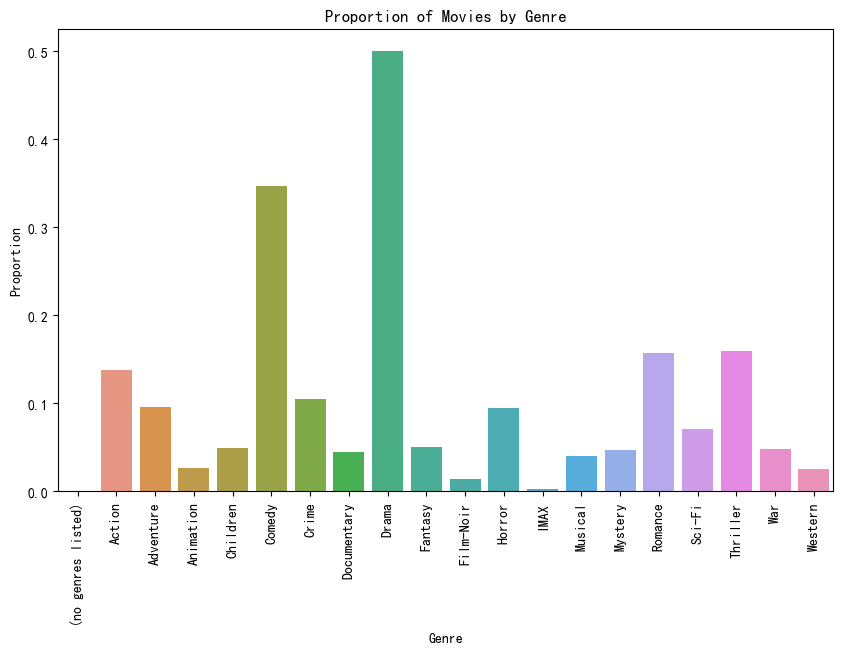

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算每种电影类型的数量
genre_counts = genres_split.apply(pd.Series.value_counts).fillna(0).sum(axis=1)

# 计算每种类型占总电影数量的比例
total_movies = len(movies)
genre_proportions = genre_counts / total_movies

# 绘制电影分类比例的直方图
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_proportions.index, y=genre_proportions.values)
plt.title('Proportion of Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Proportion')
plt.xticks(rotation=90)
plt.show()


<font face="微软雅黑" size=3 > 其中出现了（no genres listed） 和 IMAX 两种异常类型，剔除

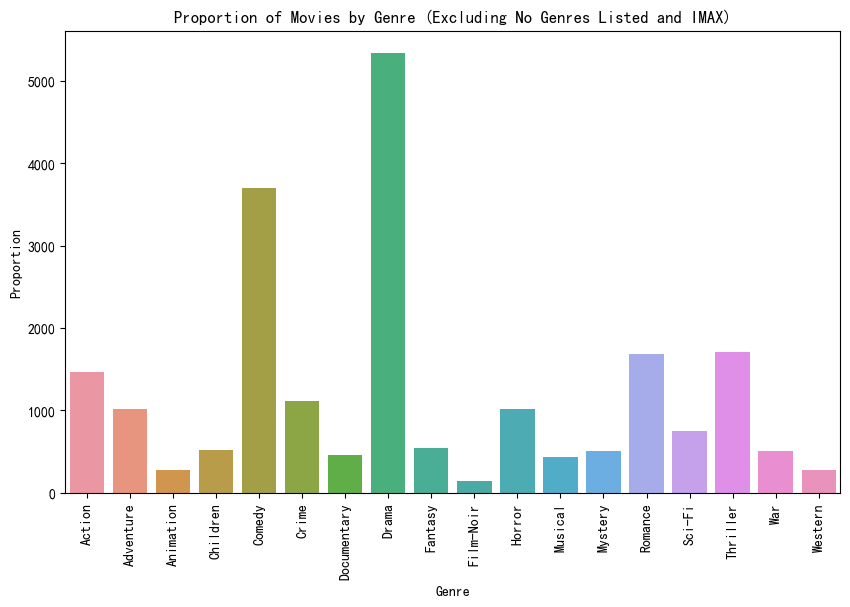

In [7]:
# 剔除异常分类
movies_cleaned = movies[(movies['genres'] != '(no genres listed)') & (~movies['genres'].str.contains('IMAX'))]

# 重新计算不同类型电影的数量
genres_split_cleaned = movies_cleaned['genres'].str.split('|', expand=True)
genre_counts_cleaned = genres_split_cleaned.apply(pd.Series.value_counts).fillna(0).sum(axis=1)

# 绘制电影类型比例的直方图
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts_cleaned.index, y=genre_counts_cleaned.values)
plt.title('Proportion of Movies by Genre (Excluding No Genres Listed and IMAX)')
plt.xlabel('Genre')
plt.ylabel('Proportion')
plt.xticks(rotation=90)
plt.show()


<font face="微软雅黑" size=3 > 统计电影评分，设定[0,5]的阈值，判断是否有异常类型

In [8]:
# 找出平方小于0或大于5的异常评分
abnormal_ratings = ratings[(ratings['rating'] < 0) | (ratings['rating'] > 5)]

# 判断异常评分的数量是否大于0
if len(abnormal_ratings) > 0:
    print("存在异常评分，数量为:", len(abnormal_ratings))
    print("异常评分的具体信息:")
    print(abnormal_ratings)
else:
    print("无异常评分")


无异常评分


<font face="微软雅黑" size=3 > 绘制不同类型的电影评分的盒图

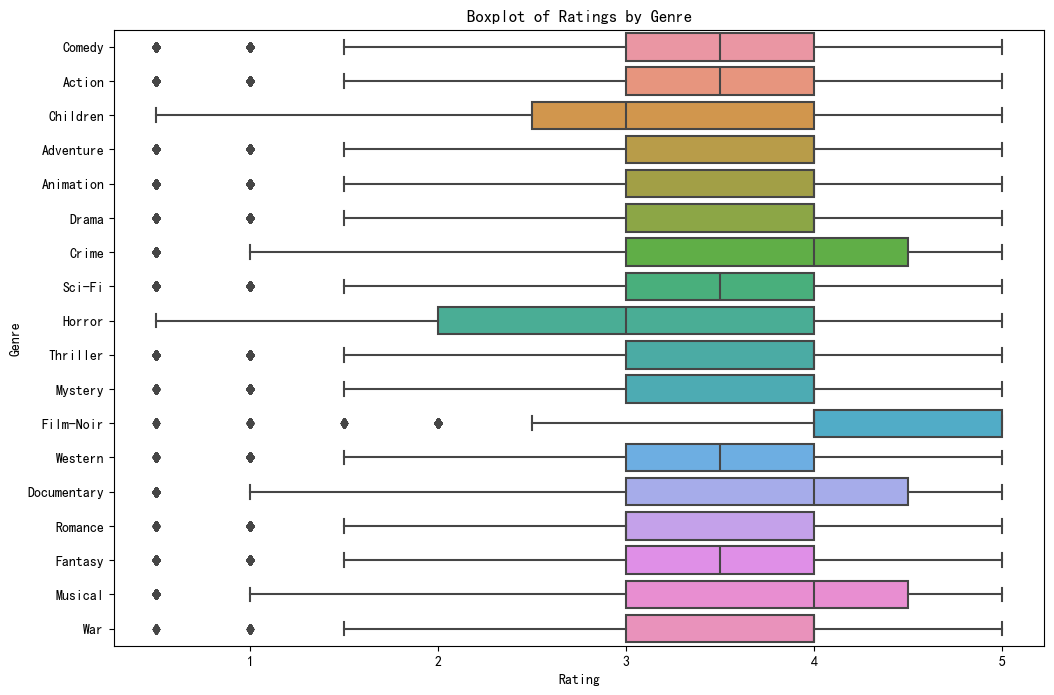

In [9]:
import seaborn as sns

# 合并电影数据集和评分数据集
merged_data = pd.merge(ratings, movies_cleaned, on='movie_id', how='inner')

# 将电影类型拆分为多列
genres_split_cleaned = merged_data['genres'].str.split('|', expand=True)

# 将拆分后的电影类型添加到合并后的数据集中
merged_data_with_genres = pd.concat([merged_data, genres_split_cleaned], axis=1)

# 绘制不同类型的电影评分盒图
plt.figure(figsize=(12, 8))
sns.boxplot(data=merged_data_with_genres, x='rating', y=0)
plt.title('Boxplot of Ratings by Genre')
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.show()


<font face="微软雅黑" size=3 > 绘制每个年份的电影数量，评分数量，设定每年评分数量>30的阈值，观察是否有异常值

In [10]:
# 计算每个年份的电影数量
movie_counts_by_year = movies_cleaned['year'].value_counts().sort_index()

# 计算每个年份的评分数量
rating_counts_by_year = merged_data.groupby('year').size().sort_index()

# 创建包含电影数量和评分数量的数据框
df_counts_by_year = pd.DataFrame({
    'Movies': movie_counts_by_year,
    'Ratings': rating_counts_by_year
})


# 打印各个年份的评分数量
print("各个年份的评分数量:")
print(rating_counts_by_year)


各个年份的评分数量:
year
1915       203
1916       101
1917        36
1918        82
1919       183
         ...  
2004    226921
2005    142915
2006    115236
2007     82567
2008     26958
Length: 94, dtype: int64


In [11]:
# 打印各个年份的电影数量
print("各个年份的电影数量:")
print(movie_counts_by_year)


各个年份的电影数量:
year
1915      1
1916      2
1917      2
1918      2
1919      4
       ... 
2004    341
2005    331
2006    344
2007    363
2008    248
Name: count, Length: 94, dtype: int64


In [12]:
# 筛选评分数量小于30的年份
years_with_few_ratings = rating_counts_by_year[rating_counts_by_year < 30]

# 打印评分数量小于30的年份
if not years_with_few_ratings.empty:
    print("评分数量小于30的年份:")
    print(years_with_few_ratings)
else:
    print("没有评分数量小于30的年份。")


没有评分数量小于30的年份。


<font face="微软雅黑" size=3 > 统计每个年份的标签数量

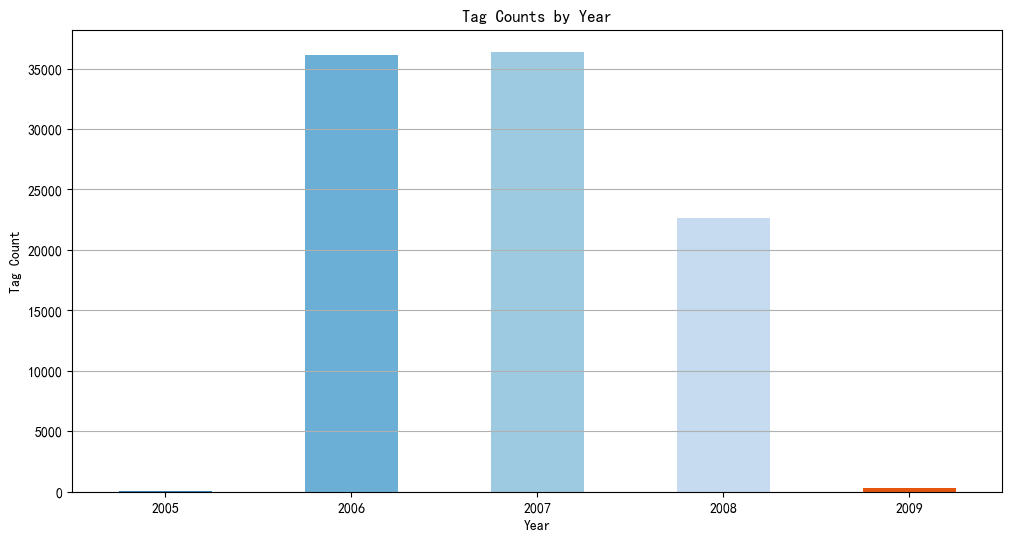

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 提取时间戳中的年份
tags['year'] = pd.to_datetime(tags['timestamp'], unit='s').dt.year

# 统计每个年份的标签数量并重新索引以包含所有可能的年份
tag_counts_by_year = tags.groupby('year').size().reindex(range(int(tags['year'].min()), int(tags['year'].max()) + 1), fill_value=0)

# 设置直方图颜色和样式
colors = plt.cm.tab20c.colors

# 绘制每个年份的标签数量的直方图
plt.figure(figsize=(12, 6))
tag_counts_by_year.plot(kind='bar', color=colors)
plt.title('Tag Counts by Year')
plt.xlabel('Year')
plt.ylabel('Tag Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


<font face="微软雅黑" size=3 > # 数量相加与官网的95580个标签一致,注意到2005年和2009年的数据都比较少,剔除

In [14]:
# 过滤掉2005年和2009年的数据
filtered_tags = tags[(tags['year'] != 2005) & (tags['year'] != 2009)]

# 按年份分组并计算每个年份的标签数量
tag_counts_by_year = filtered_tags.groupby('year').size()

# 打印每个年份的标签数量
print("每个年份的标签数量:")
print(tag_counts_by_year)


每个年份的标签数量:
year
2006    36163
2007    36395
2008    22674
dtype: int64
